In [18]:
import jax
import jax.numpy as jnp
from jax import grad, jit, random
import numpy as np
import matplotlib.pyplot as plt
import time

In [19]:
class HamiltonianMonteCarlo:
    def __init__(self, U, grad_U, epsilon, L, M):
        self.U = U  # Potential energy function
        self.grad_U = grad_U  # Gradient of the potential energy function
        self.epsilon = epsilon  # Step size
        self.L = L  # Number of leapfrog steps
        self.M = M  # Mass matrix
        self.M_inv = jnp.linalg.inv(M)  # Inverse of the mass matrix
        self.samples = None  # Placeholder for sampled points
        self.time = None  # Placeholder for sampling time
        self.acceptance_rate = None  # Placeholder for acceptance rate
        self.mean = None  # Placeholder for mean of samples
        self.covariance = None  # Placeholder for covariance of samples
    
    def leapfrog(self, q, p):
        p = p - 0.5 * self.epsilon * self.grad_U(q)
        for _ in range(self.L):
            q = q + self.epsilon * jnp.dot(self.M_inv, p)
            if _ < self.L - 1:
                p = p - self.epsilon * self.grad_U(q)
        p = p - 0.5 * self.epsilon * self.grad_U(q)
        return q, p

    def sample(self, key, num_samples):
        start_time = time.time()
        samples = []
        accepted = 0

        q = jnp.zeros(self.M.shape[0])  # Initial position
        for _ in range(num_samples):
            key, subkey = random.split(key)
            p = random.normal(subkey, shape=q.shape) * jnp.sqrt(jnp.diag(self.M))

            current_q = q
            current_p = p

            q, p = self.leapfrog(current_q, current_p)

            current_U = self.U(current_q)
            current_K = 0.5 * jnp.dot(current_p, jnp.dot(self.M_inv, current_p))
            proposed_U = self.U(q)
            proposed_K = 0.5 * jnp.dot(p, jnp.dot(self.M_inv, p))

            acceptance_prob = jnp.exp(current_U - proposed_U + current_K - proposed_K)
            if random.uniform(subkey) < acceptance_prob:
                samples.append(q)
                accepted += 1
            else:
                samples.append(current_q)
        
        end_time = time.time()
        self.samples = jnp.array(samples)
        self.time = end_time - start_time
        self.acceptance_rate = accepted / num_samples
        self.mean = jnp.mean(self.samples, axis=0)
        self.covariance = jnp.cov(self.samples, rowvar=False)


In [20]:
def multivariate_gaussian(x, mean, cov):
    diff = x - mean
    return 0.5 * jnp.dot(diff, jnp.linalg.solve(cov, diff))

# The target distribution is proportional to exp(-multivariate_gaussian(x))
def target_distribution_gauss_2d(x):
    mean = jnp.array([1.0, -1.5])
    cov = jnp.array([[4.0, 0.7], [0.7, 1.5]])  # Example covariance matrix
    return multivariate_gaussian(x, mean, cov)

In [21]:
grad_U = jit(grad(target_distribution_gauss_2d))
epsilon = 0.1
L = 10
M = jnp.eye(2)  # Identity matrix for simplicity
num_samples = 10000
key = random.PRNGKey(0)

HM_gauss_2d = HamiltonianMonteCarlo(target_distribution_gauss_2d, grad_U, epsilon, L, M)

In [22]:
HM_gauss_2d.sample(key, num_samples)

In [23]:
HM_gauss_2d.samples

Array([[ 0.39410242, -1.0321412 ],
       [ 0.5090316 , -1.270193  ],
       [-0.2773947 , -1.980434  ],
       ...,
       [-0.51995134, -0.4678173 ],
       [-0.18532878, -0.53182214],
       [ 0.4436819 ,  0.12748455]], dtype=float32)

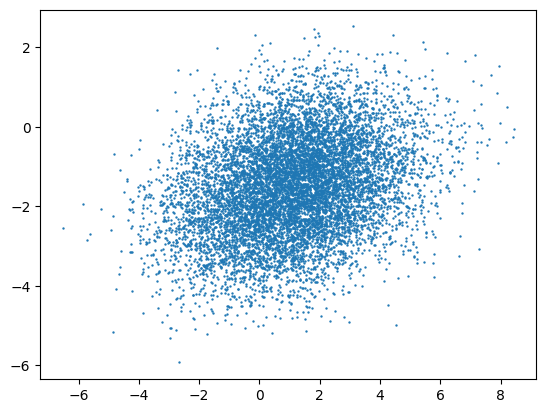

In [24]:
plt.scatter(HM_gauss_2d.samples[:,0], HM_gauss_2d.samples[:,1], s=0.5)

In [25]:
def target_distribution_gauss_15d(x):
    mean = jnp.ones(15)
    cov = jnp.eye(15)* 0.5 + 0.5 
    return multivariate_gaussian(x, mean, cov)

In [26]:
grad_U = jit(grad(target_distribution_gauss_15d))
epsilon = 0.1
L = 5
M = jnp.eye(15)  # Identity matrix for simplicity
num_samples = 10000
key = random.PRNGKey(0)

HM_gauss_15d = HamiltonianMonteCarlo(target_distribution_gauss_15d, grad_U, epsilon, L, M)

In [27]:
HM_gauss_15d.sample(key, num_samples)

In [28]:
HM_gauss_15d.mean

Array([0.99029607, 0.9620937 , 0.9810796 , 0.97960174, 1.0050257 ,
       0.9742872 , 0.96117973, 0.9630861 , 0.9949066 , 0.9791009 ,
       0.93766266, 0.98554194, 0.97095937, 1.0027475 , 0.99300176],      dtype=float32)

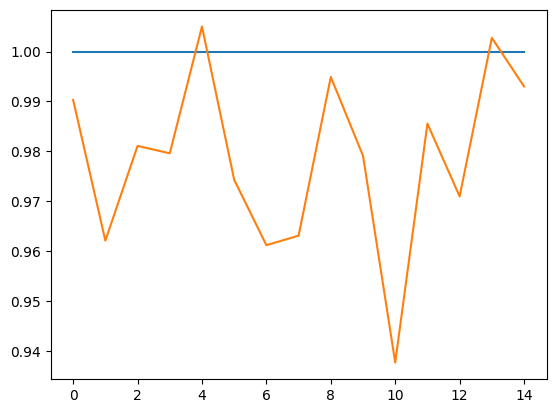

In [29]:
plt.plot(range(0,15),np.ones(15))
plt.plot(HM_gauss_15d.mean)

In [30]:
HM_gauss_15d.acceptance_rate

0.9962

In [31]:
# Define the 2-dimensional Rosenbrock function
def rosenbrock(x):
    a = 1.0
    b = 100.0
    return (a - x[0])**2 + b * (x[1] - x[0]**2)**2

# The target distribution is proportional to exp(-rosenbrock(x))
def target_distribution_rosenbrock(x):
    return rosenbrock(x)

In [40]:
grad_U = jit(grad(target_distribution_rosenbrock))
epsilon = 0.001  # Smaller step size for the Rosenbrock function
L = 100  # More steps to better explore the steep regions
M = jnp.eye(2)  # Identity mass matrix
num_samples = 10000
key = random.PRNGKey(0)

HM_gauss_rosenbrock = HamiltonianMonteCarlo(target_distribution_rosenbrock, grad_U, epsilon, L, M)

In [41]:
HM_gauss_rosenbrock.sample(key, num_samples)

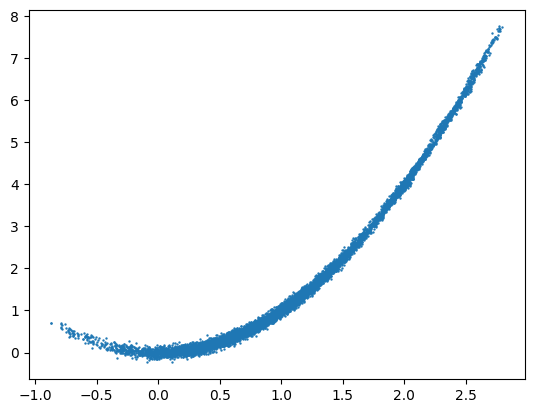

In [42]:
plt.scatter(HM_gauss_rosenbrock.samples[:,0], HM_gauss_rosenbrock.samples[:,1], s=0.5)

In [43]:
HM_gauss_rosenbrock.acceptance_rate

1.0